# CESM subsampling pi control with different 'ensemble' time periods

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIA/CESM_pi_control.ipynb)

**Input:** <br>
CESM Large Ensemble preindustrial control, [website](https://www.cesm.ucar.edu/projects/community-projects/LENS/instructions.html#ESG), [CESM LE doi](https://doi.org/10.1175/BAMS-D-13-00255.1)
- **Coupled** (years 0400-2200): `b.e11.B1850C5CN.f09_g16.005.cice.h.aice_nh*.nc` 
- **Slab-ocean** (years 0100-1001): `e.e11.E1850C5CN.f09_g16.001.cice.h.aice_nh*.nc` <br>

CESM Large Ensemble, historical and RCP8.5
- **1920-1987 (Sep) 1925-1981 (Mar)**, minimal trend during that time (20th century near constant - 20C)
- **1995-2045 (Sep) 1997-2046 (Mar)**, approximately linear trend for that time (21th century near linear trend - 21C) <br>
Both avoid years influenced by the eruption of Mount Pinatubo 
**Output:** <br>
- SIA time series for coupled and slab-ocean preindustrial controls
- Detrended SIA time series
- Standard deviation of resampled time series for all time period lengths

**Method:** <br>
- Use the 40 emsemble members from LE or 'simulate' 40 ensemble members in the preindustrial control by using randomly chosen start dates for 40 time series. **Use the same random start dates for all time period lengths**
- Allow the time series to be of length between 6 and 298 years with an interval of 4 years
- Detrend either by each time series or from the mean trend from the 40 'ensemble' members for each time period
- Resample 1000 times with a 2 year block boostrap size 
- Repeat the analysis for the preindustrial control 10 times to select different randomly chosen start years and average the results

**TO DO:** <br>
- Decide on start/end dates for 20C and 21C. Make reduced dataset files for those. Should be easy to resample these and detrend based on ensemble or individual trend 
- Redo the code to select the same random start years for all time periods
- Also look at Atmosphere-only control run, f.e11.F1850C5CN.f09_f09.001, years 1-2600 availible?



**Rationale:** <br>
- We assume that we select 20C and 21C to actually have zero trend or a linear trend. This we can take anomalies from that trend and take only 6 years for example 


- We want to make sure our selection of 40 'ensemble members' in the PI control is valid. To do this for the 20C and 21C time periods we can see if there's a difference between always starting with the same year (1920 or 1995) and using the 40 ensemble members, or just selecting 1 ensemble member (member 1 for simplicity) and following the PI control methodology of selecting random start years to produce our 40 'ensemble members'.

- For the PI control and 20C time period we just use the pure anomalies. We have effectively taken away a flat trend which should be approximately true for these time periods. In the 21C we take away only a linear trend so this is analagous to our 1979-2020 time period we then work with our anomalies from this linear trend.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math as m
import xarray as xr
import datetime
import dask
print(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d"))

data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

01:22 UTC Tue 2021-07-20


In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(cores    = 8,
                     memory   = '4GB',
                     queue    = 'regular',
                     walltime = '00:44:00')

cluster.scale(8)
client = Client(cluster)
client

# Poof of concept - compare 5 members of LE with dividing up a single member into 5 parts

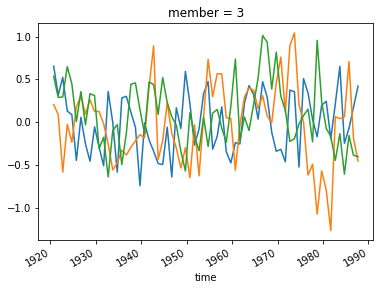

In [15]:
#use 20C September 
detrended['20C_09_ens'].sel(member=1).plot()
detrended['20C_09_ens'].sel(member=2).plot()
detrended['20C_09_ens'].sel(member=3).plot()

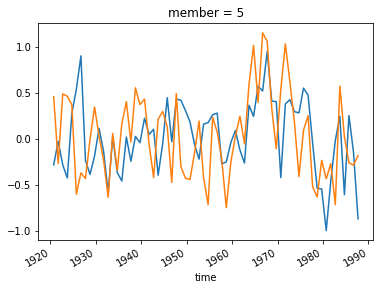

In [16]:
detrended['20C_09_ens'].sel(member=4).plot()
detrended['20C_09_ens'].sel(member=5).plot()

In [29]:
resample_n = 1000
mem_n = 5
start_i = np.arange(0,5)*m.floor(len(detrended['20C_09_ens']['time']) / mem_n)

In [125]:
all_syn_mems = []
for actual_mem in np.arange(36,41):

    synthetic_mems = []
    for time_period in np.arange(6,14,2):
        time_mems = []
        for mem_i in np.arange(0,5):
            time_mems.append(resample_boot2(detrended['20C_09_ens'].sel(member=actual_mem).isel(time=slice(start_i[mem_i],start_i[mem_i]+time_period)), resample_n))

        synthetic_mems.append(xr.concat((time_mems), dim='syn_member'))

    all_syn_mems.append(xr.concat((synthetic_mems), dim='time_period'))

all_syn_mems = xr.concat((all_syn_mems), dim='actual_members')

print(all_syn_mems.mean('actual_members').std())

<xarray.DataArray ()>
array(0.01009628)


In [126]:
intervals_members = [0.0135, 0.0153, 0.0095, 0.0126, 0.0162, 0.0141, 0.0114, 0.0101]

In [132]:
1/3.1

0.3225806451612903

In [127]:
np.mean(intervals_members)

0.0128375

In [128]:
np.std(intervals_members)

0.002240500781075516

In [130]:
(np.mean(intervals_members) - all_ream_mems_av.std()) / np.std(intervals_members)

<xarray.DataArray ()>
array(1.66001418)

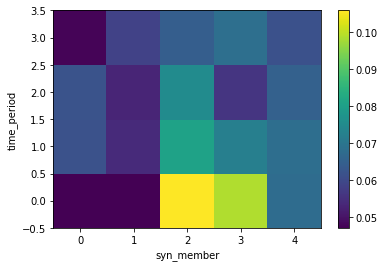

In [108]:
all_syn_mems.mean('actual_members').plot()

In [97]:
all_real_mems = []

for run in range(1000):
    if run % 100 == 0:
        print(datetime.datetime.now(), run)
        
    real_mems = []
    for time_period in np.arange(6,14,2):
        
        time_mems = []
        for mem_i in np.arange(0,5):
            rand_start = np.random.randint(0,len(detrended['20C_09_ens']['time'])-time_period-1)
            time_mems.append(resample_boot2(detrended['20C_09_ens'].isel(member=mem_i).isel(time=slice(rand_start,rand_start+time_period)), resample_n))

        real_mems.append(xr.concat((time_mems), dim='member'))

    all_real_mems.append(xr.concat((real_mems), dim='time_period'))
    
all_real_mems = xr.concat((all_real_mems), dim='run')  

2021-07-14 15:31:39.124507 0
2021-07-14 15:31:50.438616 100
2021-07-14 15:32:01.867260 200
2021-07-14 15:32:13.663888 300
2021-07-14 15:32:24.982756 400
2021-07-14 15:32:36.298493 500
2021-07-14 15:32:48.175790 600
2021-07-14 15:32:59.764030 700
2021-07-14 15:33:11.311715 800
2021-07-14 15:33:22.935868 900


In [98]:
all_ream_mems_av = all_real_mems.mean('run')

In [112]:
all_ream_mems_av.std()

<xarray.DataArray ()>
array(0.00911824)

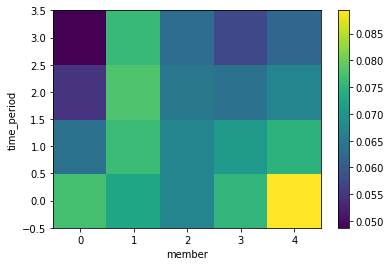

In [99]:
all_ream_mems_av.plot()

# Calculate SIA anomalies for Coupled and Slab-Ocean Pre-Industrial control runs

### Make reduced datast of SIA for whole of PI control (slab-ocean and coupled)

In [3]:
#open the pi_control files
coupled = xr.open_mfdataset('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/b.e11.B1850C5CN.f09_g16.005.cice.h.aice_nh*', concat_dim='time', chunks=104)
slab    = xr.open_mfdataset('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/e.e11.E1850C5CN.f09_g16.001.cice.h.aice_nh*', concat_dim='time', chunks=104)
#open the corresponding area file
CESM_area_file = xr.open_dataset('/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/fx/areacello/areacello_fx_CESM1-CAM5_historical_r0i0p0.nc')
area_truc = CESM_area_file['areacello'].where(CESM_area_file['lat']>35,drop=True) #drop the latitudes below 35N

In [3]:
#weight the grid cells
coupled_weighted = coupled['aice'] * area_truc.values
slab_weighted    = slab['aice'] * area_truc.values

#sum up the SIA
coupled_SIA = coupled_weighted.sum('nj').sum('ni')
slab_SIA    = slab_weighted.sum('nj').sum('ni')

#change to million square km
coupled_SIA = coupled_SIA/1e14
coupled_SIA.load()

slab_SIA    = slab_SIA/1e14
slab_SIA.load()

#change the dates to have the month be intuitive, not start of following month
new_time_coupled = []
for i in (coupled_SIA['time']): #i is each date, we will then use the charachters within each date to change to np.datetime64
    new_time_coupled.append(np.datetime64(str(i.values)[:4]+'-'+str(i.values)[5:7].zfill(2)+'-'+str(i.values)[8:10]))
new_time_coupled = new_time_coupled - np.timedelta64(16, 'D')

new_time_slab = []
for i in (slab_SIA['time']): #i is each date, we will then use the charachters within each date to change to np.datetime64
    new_time_slab.append(np.datetime64(str(i.values)[:4]+'-'+str(i.values)[5:7].zfill(2)+'-'+str(i.values)[8:10]))
new_time_slab = new_time_slab - np.timedelta64(16, 'D')

coupled_SIA['time'] = new_time_coupled
slab_SIA['time']    = new_time_slab

In [7]:
#save coupled SIA to NetCDF
coupled_SIA.attrs = {'Description': 'SIA for CESM 1 pre-industrial control (1850) coupled runs, northern hemisphere, time 0400-2200.', 
                     'Units'      : 'Million square km',
                     'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                     'Data source': '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/b.e11.B1850C5CN.f09_g16.005.cice.h.aice_nh.*.nc (doi:10.1175/BAMS-D-13-00255.1)',
                     'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/CESM_pi_control.ipynb'}

coupled_SIA.to_netcdf(data_path+'Raw_data/CESM_pi_control/CESM_pi_control_1850_coupled_SIA_0400_2200.nc')

#save slab SIA to NetCDF
slab_SIA.attrs = {'Description': 'SIA for CESM 1 pre-industrial control (1850) slab-ocean runs, northern hemisphere, time 0100-1001.', 
                  'Units'      : 'Million square km',
                  'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                  'Data source': '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/e.e11.E1850C5CN.f09_g16.001.cice.h.aice_nh*.nc (doi:10.1175/BAMS-D-13-00255.1)',
                  'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/CESM_pi_control.ipynb'}

slab_SIA.to_netcdf(data_path+'Raw_data/CESM_pi_control/CESM_pi_control_1850_slab_SIA_0100_1001.nc')

### Compute anomalies for Coupled and Slab

In [ ]:
#take away the mean for each month
coupled_anomalies = coupled_SIA.groupby('time.month') - coupled_SIA.groupby('time.month').mean('time')
slab_anomalies    = slab_SIA.groupby('time.month') - slab_SIA.groupby('time.month').mean('time')

#save coupled SIA anomalies to NetCDF
coupled_anomalies.attrs = {'Description': 'SIA anomalies for CESM 1 pre-industrial control (1850) coupled runs, northern hemisphere, time 0400-2200. Anomalies relative to the mean for each month', 
                           'Units'      : 'Million square km',
                           'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                           'Data source': '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/b.e11.B1850C5CN.f09_g16.005.cice.h.aice_nh.*.nc (doi:10.1175/BAMS-D-13-00255.1)',
                           'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/CESM_pi_control.ipynb'}

coupled_anomalies.to_netcdf(data_path+'Raw_data/CESM_pi_control/CESM_pi_control_1850_coupled_SIA_anomalies_0400_2200.nc')

#save slab SIA anomalies to NetCDF
slab_anomalies.attrs = {'Description': 'SIA anomalies for CESM 1 pre-industrial control (1850) slab-ocean runs, northern hemisphere, time 0100-1001. Anomalies relative to the mean for each month', 
                        'Units'      : 'Million square km',
                        'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                        'Data source': '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/e.e11.E1850C5CN.f09_g16.001.cice.h.aice_nh*.nc (doi:10.1175/BAMS-D-13-00255.1)',
                        'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/CESM_pi_control.ipynb'}

slab_anomalies.to_netcdf(data_path+'Raw_data/CESM_pi_control/CESM_pi_control_1850_slab_SIA_anomalies_0100_1001.nc')

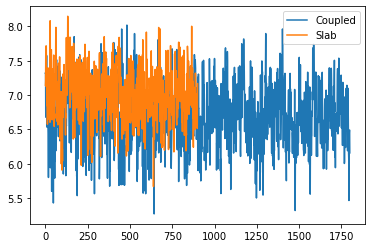

In [21]:
coupled_SIA = xr.open_dataset('/glade/work/cwpowell/CLIVAR_area_extent_files/CESM_pi_control_1850_coupled_SIA_09.nc')
slab_SIA = xr.open_dataset('/glade/work/cwpowell/CLIVAR_area_extent_files/CESM_pi_control_1850_slab_SIA_0100_1001.nc')

plt.plot(coupled_SIA['aice'], label='Coupled')
plt.plot(slab_SIA['aice'].sel(time=slab_SIA['time.month']==9), label='Slab')
plt.legend()

# Compute SIA anomalies for 20C and 21C

In [2]:
#load the SIA from CESM1 LE 1850-2100
SIA_models = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')

### Identify SIA time period that is near constant and near linear trend for September SIA


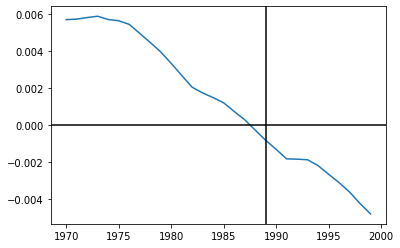

In [19]:
#firstly see where the gradient of the trend is near constant for identifying 20C 
ends = np.arange(1970,2000)
coefs = []
for end in ends:
    coefs.append(np.polyfit(np.arange(1920,end+1), SIA_models['CESM1'].sel(time=SIA_models['time.month']==9).mean('member').sel(time=slice('1920-01','{}-12'.format(end))), 1)[0])
    
plt.plot(ends, coefs)
plt.axhline(0, c='k')
plt.axvline(1989, c='k');

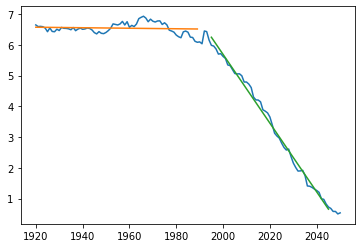

In [18]:
#plot linear trends for the chosen time periods
plt.plot(np.arange(1920,2051), SIA_models['CESM1'].sel(time=SIA_models['time.month']==9).mean('member').sel(time=slice('1920','2050')))

coefs = np.polyfit(np.arange(1920,1990), SIA_models['CESM1'].sel(time=SIA_models['time.month']==9).mean('member').sel(time=slice('1920','1989')),1)
plt.plot(np.arange(1920,1990), coefs[0]*np.arange(1920,1990) + coefs[1])

coefs = np.polyfit(np.arange(1995,2046), SIA_models['CESM1'].sel(time=SIA_models['time.month']==9).mean('member').sel(time=slice('1995','2045')),1)
plt.plot(np.arange(1995,2046), coefs[0]*np.arange(1995,2046) + coefs[1])

### Identify dates for March

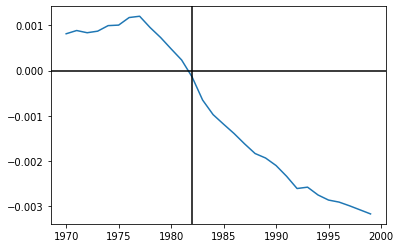

In [9]:
#firstly see where the gradient of the trend is near constant for identifying 20C 
ends = np.arange(1970,2000)
coefs = []
for end in ends:
    coefs.append(np.polyfit(np.arange(1925,end+1), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1925-01','{}-12'.format(end))), 1)[0])
    
plt.plot(ends, coefs)
plt.axhline(0, c='k')
plt.axvline(1982, c='k');

1925 1981 0.0002323167448313938
1925 1982 -0.00014294920589864345


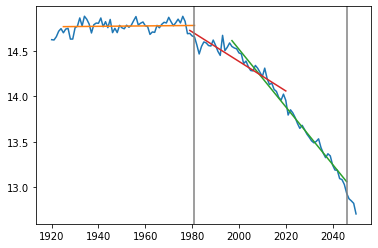

In [20]:
#plot linear trends for the chosen time periods
plt.plot(np.arange(1920,2051), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1920','2050')))

coefs = np.polyfit(np.arange(1925,1982), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1925','1981')),1)
plt.plot(np.arange(1925,1982), coefs[0]*np.arange(1925,1982) + coefs[1])

coefs = np.polyfit(np.arange(1997,2047), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1997','2046')),1)
plt.plot(np.arange(1997,2047), coefs[0]*np.arange(1997,2047) + coefs[1]);

coefs = np.polyfit(np.arange(1979,2021), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1979','2020')),1)
plt.plot(np.arange(1979,2021), coefs[0]*np.arange(1979,2021) + coefs[1]);

plt.axvline(1981, c='0.5');
plt.axvline(2046, c='0.5');

print('1925','1981',np.polyfit(np.arange(1925,1982), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1925','1981')),1)[0])
print('1925','1982',np.polyfit(np.arange(1925,1983), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1925','1982')),1)[0])

## Look at CESM LE 1850-2000 near constant for member 1, compare with PI control?

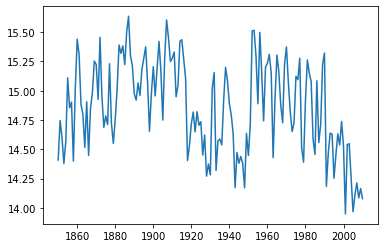

In [3]:
#plot linear trends for the chosen time periods
plt.plot(np.arange(1850,2011), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).sel(member=1).sel(time=slice('1850','2010')))

# coefs = np.polyfit(np.arange(1925,1982), SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).mean('member').sel(time=slice('1925','1981')),1)
# plt.plot(np.arange(1925,1982), coefs[0]*np.arange(1925,1982) + coefs[1])


## Detrend for 20C and 21C time periods
- 20C Sep: 1920-1987, 68 years
- 20C Mar: 1925-1981, 57 years
- 21C Sep: 1995-2045, 51 years
- 21C Mar: 1997-2046, 49 years

In [3]:
SIA_20C_09 = SIA_models['CESM1'].sel(time=SIA_models['time.month']==9).sel(time=slice('1920','1987')).sel(member=slice(0,40))
SIA_20C_03 = SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).sel(time=slice('1925','1981')).sel(member=slice(0,40))

SIA_21C_09 = SIA_models['CESM1'].sel(time=SIA_models['time.month']==9).sel(time=slice('1995','2045')).sel(member=slice(0,40))
SIA_21C_03 = SIA_models['CESM1'].sel(time=SIA_models['time.month']==3).sel(time=slice('1997','2046')).sel(member=slice(0,40))

In [4]:
def detrend_ens_ind(data, start_yr, end_yr):
    '''
    detrends relative to the ensemble mean and the individual member
    '''

    #detrend with ensemble mean 
    coefs = np.polyfit(np.arange(start_yr,end_yr+1), data.mean('member').values, 1)
    ens_trend = xr.DataArray(data=(np.arange(start_yr,end_yr+1)*coefs[0])+coefs[1], coords={'time':data['time']}, dims='time')
    anomalies_ens = data - ens_trend

    #detrend individual members
    anomalies_ind = []
    for mem_i, mem in enumerate(np.arange(1,41)):
        coefs = np.polyfit(np.arange(start_yr,end_yr+1), data.sel(member=mem).values, 1)
        tred_ind = (np.arange(start_yr, end_yr+1) * coefs[0]) + coefs[1]
        anomalies_ind.append(xr.DataArray(data=data.sel(member=mem)-tred_ind, coords={'time':data['time']}, dims='time'))

    anomalies_ind = xr.concat((anomalies_ind), dim='member')
    anomalies_ind['member'] = np.arange(1,41)

    return(anomalies_ens, anomalies_ind)

In [5]:
#make a dictionary for all the detrended time series
detrended = {}

for i, ens_ind in enumerate(['ens', 'ind']):
    detrended['20C_09_{}'.format(ens_ind)] = detrend_ens_ind(SIA_20C_09, 1920, 1987)[i]
    detrended['20C_03_{}'.format(ens_ind)] = detrend_ens_ind(SIA_20C_03, 1925, 1981)[i]
    detrended['21C_09_{}'.format(ens_ind)] = detrend_ens_ind(SIA_21C_09, 1995, 2045)[i]
    detrended['21C_03_{}'.format(ens_ind)] = detrend_ens_ind(SIA_21C_03, 1997, 2046)[i]

# Resample

In [42]:
def resample_boot2(data, resample_n):
    
    '''
    Returns resamplings of a given time series of length equal to time period 
    '''
    
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,len(data)-2, (resample_n,int(len(data)/2))), 
                                    coords = {'resampling':np.arange(1,resample_n+1), 'year_i':np.arange(1,len(data)+1,2)},
                                    dims   = ['resampling', 'year_i'])

    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,len(data)+2,2)

    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    ind_base = np.repeat(np.arange(0,len(data)*resample_n,len(data)),len(data))
    
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base

    SIA_mem_1000 = np.ravel(np.tile(data,(len(data),resample_n)))

    resample_boot_2 = xr.DataArray(data = np.reshape(SIA_mem_1000[ind_1_d], (len(data),resample_n)),
                                   coords = {'year_i':np.arange(1,len(data)+1,1), 'resampling':np.arange(1,resample_n+1,1)},
                                   dims   = ['year_i', 'resampling'])

    return(resample_boot_2.std('year_i').std('resampling'))

## Resample detrended data for 20C and 21C
We pick a random start date as we want to simulate what it's like to have a subset of data from a longer period with a known linear trend

**N.B. if chosing a random start date, for the longer time periods we have very few dates to choose from so we are really just using the full time period**

In [74]:
all_resampled = {}
for key in list(detrended.keys())[:2]:
    print(datetime.datetime.now(), key)
    
    key_resampled = []
#     for time_period in np.arange(6,len(detrended[key]['time'])+1,2):
    for time_period in np.arange(6,49,2):
        
        all_runs = []
        for run_ in range(50):
            rand_start = np.random.randint(0,len(detrended[key]['time'])-time_period-1)
            all_runs.append(resample_boot2(detrended[key].isel(time=slice(rand_start,rand_start+time_period-1)), 1000))
        
        all_runs = xr.concat((all_runs), dim='run')    
        key_resampled.append(all_runs.mean('run'))
    
    key_all_resampled = xr.concat((key_resampled), dim='time_period')
#     key_all_resampled['time_period'] = np.arange(6,len(detrended[key]['time'])+1,2)
    key_all_resampled['time_period'] = np.arange(6,49,2)
    all_resampled[key] = key_all_resampled

2021-07-13 15:18:37.171820 20C_09_ens
2021-07-13 15:19:09.619334 20C_03_ens


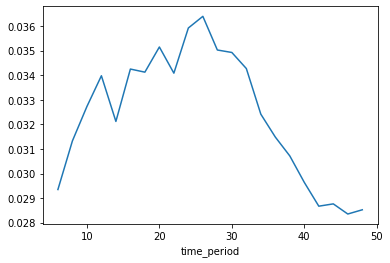

In [75]:
all_resampled['20C_03_ens'].plot()

In [ ]:
#save to netcdf
all_resampled = xr.Dataset(all_resampled)

all_resampled.attrs = {'Description': 'Resampled CESM LE, northern hemisphere sea ice area. Time periods for near constant SIA: 1925-1981 (March), 1920-1987 (September), approximate linear trend: 1997-2046 (March), 1995-2045 (September). '+\ 
                       'A given length of the anoamlies from these time series is taken from 6 years to the full length of the time series in 2 year intervals. 50 random start dates within the time series are taken at random '+\
                       'The anomalies are calculate in 2 ways, Ens - detrended by the ensemble mean, Ind - detrended using the individual member trend. When calculating the resamplings, 1000 resamplings are ', 
                       'Units'      : 'Million square km',
                       'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                       'Data source': '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/e.e11.E1850C5CN.f09_g16.001.cice.h.aice_nh.*.nc (doi:10.1175/BAMS-D-13-00255.1)',
                       'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/obs-ensemble/CESM_pi_control.ipynb'}
    

# Define resampling functions

In [ ]:
def resample_CESM_pi_control(SIA, month_, resample_n, time_period, max_t, start_yrs):
    '''
    function info 
    '''

In [8]:
#this function computes resamplings for ONE TIME PERIOD and ONE MONTH
#THIS funtion runs a lot faster as it uses indexing rather than nested for loops

'''Need to make sure to pick random numbers for all resamplings time periods'''

def resample_1period_1month_matrix(SIA, month_, resample_n, time_period, max_t, start_yr=False):      
    
    #initialize arrays, shape [time period, member, resampling or largest time series]
    sd_resamp_ens = np.empty((40, int(resample_n)))*np.nan
    sd_resamp_ind = np.empty((40, int(resample_n)))*np.nan

    SIA_mem   = np.empty((40, max_t))*np.nan
    mem_anom  = np.empty((40, max_t))*np.nan
    mem_coefs = np.empty((40, 2))*np.nan
    
    if rand_start_yr == False #define the starting years by random
        if str(SIA['time'][0].values)[1] == '4': #then it's the coupled dataset
            start_yrs = np.random.randint(400, 2200-time_period, 40) #generate random start dates
        else:
            start_yrs = np.random.randint(101, 1001-time_period, 40) #generate random start dates
    
    else: #use a specific starting year
        start_yrs = np.ones(40) * start_yr
        

    #################### loop through all the 'members' ###################
    for mem_i in range(40): 
        #define the years to select from the random start date
        yr_list = np.arange(start_yrs[mem_i], start_yrs[mem_i]+time_period, 1)

        #select the years from the SIA time series
        SIA_mem[mem_i][:time_period] = SIA.sel(time=SIA['time.month']==month_).sel(time=slice(str(yr_list[0]).zfill(4),str(yr_list[-1]).zfill(4))).values
        
        #calculate the linear trend coefficients and compute the anomalies from the lienar trend
        mem_coefs[mem_i] = np.polyfit(yr_list, SIA_mem[mem_i][:time_period], 1)
        mem_anom[mem_i][:time_period] = SIA_mem[mem_i][:time_period] - (mem_coefs[mem_i][0] * yr_list + mem_coefs[mem_i][1])

        ###################### compute the resamplings #########################            
        sd_resamp1[mem_i]        = resample_boot1(time_period, mem_anom[mem_i][:time_period]).std('year_i')
        sd_resamp_no_det1[mem_i] = resample_boot1(time_period, SIA_mem[mem_i][:time_period]).std('year_i')
        sd_resamp2[mem_i]        = resample_boot2(time_period, mem_anom[mem_i][:time_period]).std('year_i')
        sd_resamp_no_det2[mem_i] = resample_boot2(time_period, SIA_mem[mem_i][:time_period]).std('year_i')

    output = xr.Dataset(data_vars={'sd_resamp2'        : (('member','resampling'), sd_resamp2),
                                   'sd_resamp_no_det2' : (('member','resampling'), sd_resamp_no_det2),
                                   'SIA_mem'           : (('member','year_i'), SIA_mem),
                                   'mem_anom'          : (('member','year_i'), mem_anom),
                                   'mem_coefs'         : (('member', 'coef'), mem_coefs),
                                   'start_yrs'        : (('member'), start_yrs)},
                           
                           coords={'member'     : np.arange(1,41,1), 
                                   'resampling' : np.arange(1,resample_n+1,1), 
                                   'year_i'     : np.arange(1,max_t+1,1),
                                   'coef'       : ['gradient','intercept']})
    
    return(output)

## Resample the two eras with 6-70 or 6-54 year length time series, interval of 1 year

In [ ]:
resamp_n = 1000
start_t = 6
end_t = 55
inc_t = 1

month_ = 9 #just do September and March to start with  

for run_ in np.arange(1,11,1):
    print(datetime.datetime.now(), run_)

    result_list = []
    
    for t_period in np.arange(start_t, end_t, inc_t):                  #pi_SIA pi_slab_SIA
        result_list.append(dask.delayed(resample_1period_1month_matrix)(pi_slab_SIA, month_, resamp_n, t_period, end_t))
        
    results_computed = dask.compute(*result_list)
    
    results_computed = xr.concat((results_computed), dim='time_period')
    results_computed['time_period'] = np.arange(start_t, end_t, inc_t) 
    
   
    results_computed['sd_resamp2'].attrs        = {'Description': 'Standard deviation with respect to time for each detrended resampling, bootstrap size of 2 years'}
   
    results_computed['SIA_mem'].attrs           = {'Description': 'The original ramdonly chosen SIA time series for each member without detrending or resampling'}
    results_computed['mem_anom'].attrs          = {'Description': 'Anomalies of the SIA time series relative to a linear trend'}
    results_computed['mem_coefs'].attrs         = {'Description': 'Gradient and y-intercept of the linear trend for each SIA time series'}
    results_computed['start_yrs'].attrs         = {'Description': 'Randomly chosen start years for the SIA time series'}

                                                                                   #coupled slab-ocean      
    results_computed.attrs = {'Description': 'CESM 1 pre-industrial control (1850) slab-ocean run, northern hemisphere sea ice area, month of {}. 40 - so called - members are chosen from random start dates. The length of the times series used varies 6,10,14..298 years. 1000 resamplings are taken for each member'.format(month_names[month_-2]), 
                              'Units'      : 'Million square km',
                              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                #b.e11.B1850C5CN.f09_g16.005 e.e11.E1850C5CN.f09_g16.001
                              'Data source': '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/e.e11.E1850C5CN.f09_g16.001.cice.h.aice_nh.*.nc (doi:10.1175/BAMS-D-13-00255.1)',
                              'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/obs-ensemble/CESM_pi_control.ipynb'}
    
    if month_ == 1:
        true_month = '12'
    else:
        true_month = str(month_-1)
                                                                                         #coupled slab                  
    results_computed.to_netcdf('/glade/work/cwpowell/CLIVAR_area_extent_files/pi_control_slab_CESM_SD_time_month_{}_resampling_1000_run_{}.nc'.format(true_month.zfill(2), run_))

In [ ]:
#compare with existing data from the 1979-2020 resampling 

## Resample the Preindustrial control data

We make 40 ensembles like the CESM1 LE <br>
The total length of time of the control runs are 900 or 1800 years <br>
We want to test resampling of 40 time series of length 6-250 years

In [4]:
#load the SIA from computations
pi_SIA      = xr.open_dataarray(data_path+'Raw_data/CESM_pi_control/CESM_pi_control_1850_coupled_SIA_0400_2200.nc')
pi_slab_SIA = xr.open_dataarray(data_path+'Raw_data/CESM_pi_control/CESM_pi_control_1850_slab_SIA_0100_1001.nc')

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

In [84]:
def resample_boot2(data, time_period):
    
    '''
    Returns 1000 resamplings of a given time series of length equal to time period 
    '''
    
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,time_period-2, (1000,int(time_period/2))), 
                                    coords = {'resampling':np.arange(1,1001,1), 'year_i':np.arange(1,time_period+1,2)},
                                    dims   = ['resampling', 'year_i'])

    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,time_period+2,2)

    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    ind_base = np.repeat(np.arange(0,time_period*1000,time_period),time_period)
    
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base

    SIA_mem_1000 = np.ravel(np.tile(data,(time_period,1000)))

    resample_boot_2 = xr.DataArray(data = np.reshape(SIA_mem_1000[ind_1_d], (time_period,1000)),
                                   coords = {'year_i':np.arange(1,time_period+1,1), 'resampling':np.arange(1,1001,1)},
                                   dims   = ['year_i', 'resampling'])

    return(resample_boot_2)

In [6]:
# def resample_boot1(time_period, data):
#     boot_1_ind = xr.DataArray(data   = np.random.randint(0,time_period-1, (1000,int(time_period))), 
#                               coords = {'resampling':np.arange(1,1001,1), 'year_i':np.arange(1,time_period+1,1)},
#                               dims   = ['resampling', 'year_i'])
    
#     ind_base = np.repeat(np.arange(0,time_period*1000,time_period),time_period)
#     ind_1_d = np.ravel(boot_1_ind) + ind_base
    
#     SIA_mem_1000 = np.ravel(np.tile(data,(time_period,1000)))

#     resample_boot_1 = xr.DataArray(data = np.reshape(SIA_mem_1000[ind_1_d], (time_period,1000)),
#                                    coords = {'year_i':np.arange(1,time_period+1,1), 'resampling':np.arange(1,1001,1)},
#                                    dims   = ['year_i', 'resampling'])

#     return(resample_boot_1)

### Use Dask to compute the resampling for all months

In [ ]:
#now try with dask for all months #N.B need to change the function, description, data source, and save path with slab verses coupled
bootsize = 2
resamp_n = 1000
start_t = 6
end_t = 300
inc_t = 4

month_ = 10 

for run_ in np.arange(1,11,1):
    print(datetime.datetime.now(), run_)

    result_list = []
    
    '''DEFINE RANDOM START YEARS HERE, NOT WITHIN LOOP'''
    
    
    for t_period in np.arange(start_t, end_t, inc_t):                  #pi_SIA pi_slab_SIA
        result_list.append(dask.delayed(resample_1period_1month_matrix)(pi_slab_SIA, month_, resamp_n, t_period, end_t))
        
    results_computed = dask.compute(*result_list)
    
    results_computed = xr.concat((results_computed), dim='time_period')
    results_computed['time_period'] = np.arange(start_t, end_t, inc_t) 
    
   
    results_computed['sd_resamp2'].attrs        = {'Description': 'Standard deviation with respect to time for each detrended resampling, bootstrap size of 2 years'}
   
    results_computed['SIA_mem'].attrs           = {'Description': 'The original ramdonly chosen SIA time series for each member without detrending or resampling'}
    results_computed['mem_anom'].attrs          = {'Description': 'Anomalies of the SIA time series relative to a linear trend'}
    results_computed['mem_coefs'].attrs         = {'Description': 'Gradient and y-intercept of the linear trend for each SIA time series'}
    results_computed['start_yrs'].attrs         = {'Description': 'Randomly chosen start years for the SIA time series'}

                                                                                   #coupled slab-ocean      
    results_computed.attrs = {'Description': 'CESM 1 pre-industrial control (1850) slab-ocean run, northern hemisphere sea ice area, month of {}. 40 - so called - members are chosen from random start dates. The length of the times series used varies 6,10,14..298 years. 1000 resamplings are taken for each member'.format(month_names[month_-2]), 
                              'Units'      : 'Million square km',
                              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                #b.e11.B1850C5CN.f09_g16.005 e.e11.E1850C5CN.f09_g16.001
                              'Data source': '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/e.e11.E1850C5CN.f09_g16.001.cice.h.aice_nh.*.nc (doi:10.1175/BAMS-D-13-00255.1)',
                              'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/obs-ensemble/CESM_pi_control.ipynb'}
    
    if month_ == 1:
        true_month = '12'
    else:
        true_month = str(month_-1)
                                                                                         #coupled slab                  
    results_computed.to_netcdf('/glade/work/cwpowell/CLIVAR_area_extent_files/pi_control_slab_CESM_SD_time_month_{}_resampling_1000_run_{}.nc'.format(true_month.zfill(2), run_))

2021-06-10 17:47:12.226544 1
2021-06-10 17:51:38.702983 2
2021-06-10 17:56:06.151409 3
2021-06-10 18:00:23.517518 4
2021-06-10 18:05:04.253485 5
2021-06-10 18:09:15.912360 6
2021-06-10 18:13:57.209075 7
2021-06-10 18:17:59.071629 8
2021-06-10 18:22:28.026551 9
2021-06-10 18:26:29.918819 10
